In [1]:
# trying to get some good results with vgg16
# things to try, batchnormed vgg16

In [121]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices() 

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10971080971000754030, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 312213504
 locality {
   bus_id: 1
 }
 incarnation: 1038396111316725881
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:04:00.0"]

# setup

In [122]:
import h5py
import numpy as np
import PIL

from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers import Input, GlobalAveragePooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
from keras import optimizers
from keras import applications
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications.vgg16 import VGG16

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [123]:
import os
import numpy as np
from glob import glob
import pandas as pd

CUR_DIR = os.getcwd()
DATA_DIR = os.path.join('/scratch', 'yns207', 'data_invasive')
W_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
print(CUR_DIR, DATA_DIR)
path = DATA_DIR
test_path = os.path.join(path, 'test')
models_path = os.path.join(path, 'results')
train_path = os.path.join(path, 'train')
valid_path = os.path.join(path, 'valid')
batch_size = 64

/home/yns207/nbs/machine_learning/invasive /scratch/yns207/data_invasive


# make the model 

In [124]:
base_model = VGG16(weights='imagenet', include_top=False)

In [125]:
for layer in base_model.layers:
    layer.trainable = False
    
top_model = base_model.get_layer('block5_conv3').output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1, activation='sigmoid')(top_model)

model = Model(inputs=base_model.input, outputs=top_model)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=0.001),
              metrics=['accuracy'])

In [56]:
# gen = image.ImageDataGenerator()
# gen_t = image.ImageDataGenerator(rescale=1., 
#             featurewise_center=True,
#             rotation_range=10,
#             width_shift_range=.1,
#             height_shift_range=.1,
#             shear_range=0.2,
#             zoom_range=0.2,
#             horizontal_flip=True,
#             vertical_flip=False,
#             fill_mode="reflect")


# gen.mean = np.array([111.32052594, 121.25063492, 103.65633209]).reshape(1,1,3)
# gen_t.mean = np.array([111.32052594, 121.25063492, 103.65633209]).reshape(1,1,3)

# tr_batches = gen.flow_from_directory(train_path, 
#                                      target_size=(224,224), 
#                                      class_mode='binary', 
#                                      shuffle=True, 
#                                      batch_size=batch_size)

# tr_batches_aug = gen_t.flow_from_directory(train_path, 
#                                      target_size=(224,224), 
#                                      class_mode='binary', 
#                                      shuffle=True, 
#                                      batch_size=batch_size)

# va_batches = gen.flow_from_directory(valid_path, 
#                                      target_size=(224,224), 
#                                      class_mode='binary', 
#                                      shuffle=False, 
#                                      batch_size=batch_size)

# te_batches = gen.flow_from_directory(test_path, 
#                                      target_size=(224,224), 
#                                      class_mode='binary', 
#                                      shuffle=False, 
#                                      batch_size=batch_size)

Found 1836 images belonging to 2 classes.
Found 1836 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Found 1531 images belonging to 1 classes.


In [141]:
# first train 300 by 225
# next train on 600 by 450
img_width = 600  # Change image size for training here
img_height = 450 # Change image size for training here

batch_size = 5 # i achieved good and fast results with this small minibatch size for training
batch_size_val = 400 # if Tensorflow throws a memory error while validating at end of epoch, decrease validation batch size her

# set data augmentation parameters here
datagen = image.ImageDataGenerator(rescale=1., 
    featurewise_center=True,
    rotation_range=10,
    width_shift_range=.1,
    height_shift_range=.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="reflect")

# normalization neccessary for correct image input to VGG16
datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

# no data augmentation for validation and test set
validgen = image.ImageDataGenerator(rescale=1., featurewise_center=True)
validgen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)


train_gen = datagen.flow_from_directory(
        train_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        shuffle=True, 
        #save_to_dir="_augmented_images/", 
        #save_prefix="aug_"
        )

val_gen = validgen.flow_from_directory(
        valid_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        shuffle=True)

test_gen = validgen.flow_from_directory(
        test_path,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode="binary",
        shuffle=False)

train_samples = len(train_gen.filenames)
validation_samples = len(val_gen.filenames)
test_samples = len(test_gen.filenames)

Found 1836 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Found 1531 images belonging to 1 classes.


In [129]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

hist = model.fit_generator(train_gen,
                    steps_per_epoch=(train_gen.n//batch_size)+1,
                    validation_data=val_gen,
                    validation_steps=(val_gen.n//batch_size)+1,
                    epochs=10,
                    callbacks=[early_stopping])

Epoch 1/10
368/368 [==============================] - 75s - loss: 0.3204 - acc: 0.8717 - val_loss: 0.2022 - val_acc: 0.9325
Epoch 2/10
368/368 [==============================] - 73s - loss: 0.2728 - acc: 0.9022 - val_loss: 0.1808 - val_acc: 0.9281
Epoch 3/10
368/368 [==============================] - 73s - loss: 0.2476 - acc: 0.9174 - val_loss: 0.2210 - val_acc: 0.9434
Epoch 4/10
368/368 [==============================] - 73s - loss: 0.2341 - acc: 0.9185 - val_loss: 0.2022 - val_acc: 0.9281
Epoch 5/10
368/368 [==============================] - 73s - loss: 0.2332 - acc: 0.9255 - val_loss: 0.1680 - val_acc: 0.9499
Epoch 6/10
368/368 [==============================] - 73s - loss: 0.2368 - acc: 0.9255 - val_loss: 0.2094 - val_acc: 0.9499
Epoch 7/10
368/368 [==============================] - 73s - loss: 0.2223 - acc: 0.9212 - val_loss: 0.3629 - val_acc: 0.9194
Epoch 8/10
368/368 [==============================] - 73s - loss: 0.2193 - acc: 0.9321 - val_loss: 0.1381 - val_acc: 0.9564
Epoch 9/

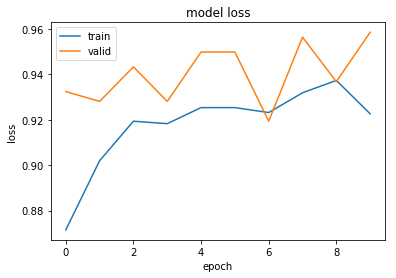

In [130]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
# now train on bigger images

In [132]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

hist2 = model.fit_generator(train_gen,
                    steps_per_epoch=(train_gen.n//batch_size)+1,
                    validation_data=val_gen, 
                    validation_steps=(val_gen.n//batch_size)+1,
                    epochs=10,
                    callbacks=[early_stopping])

Epoch 1/10
368/368 [==============================] - 268s - loss: 0.2478 - acc: 0.9255 - val_loss: 0.1248 - val_acc: 0.9477
Epoch 2/10
368/368 [==============================] - 267s - loss: 0.2011 - acc: 0.9250 - val_loss: 0.1103 - val_acc: 0.9651
Epoch 3/10
368/368 [==============================] - 267s - loss: 0.2178 - acc: 0.9332 - val_loss: 0.1490 - val_acc: 0.9521
Epoch 4/10
368/368 [==============================] - 267s - loss: 0.2043 - acc: 0.9342 - val_loss: 0.1485 - val_acc: 0.9542
Epoch 5/10
368/368 [==============================] - 267s - loss: 0.2144 - acc: 0.9342 - val_loss: 0.1362 - val_acc: 0.9542
Epoch 6/10
368/368 [==============================] - 267s - loss: 0.1843 - acc: 0.9413 - val_loss: 0.1075 - val_acc: 0.9695
Epoch 7/10
368/368 [==============================] - 268s - loss: 0.1819 - acc: 0.9429 - val_loss: 0.2661 - val_acc: 0.9434
Epoch 8/10
368/368 [==============================] - 267s - loss: 0.1865 - acc: 0.9402 - val_loss: 0.1518 - val_acc: 0.9651


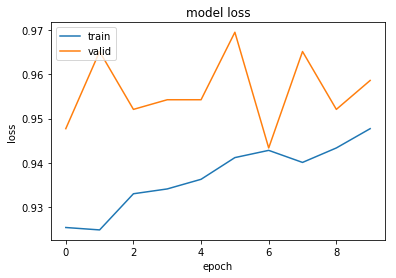

In [133]:
plt.plot(hist2.history['acc'])
plt.plot(hist2.history['val_acc'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [134]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_11
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 global_average_pooling2d_8
19 dense_25
20 dropout_13
21 dense_26


In [136]:
for layer in model.layers[:15]:
   layer.trainable = False
for layer in model.layers[15:]:
   layer.trainable = True

In [137]:
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [139]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

hist3 = model.fit_generator(train_gen,
                    steps_per_epoch=(train_gen.n//batch_size)+1,
                    validation_data=val_gen,
                    validation_steps=(val_gen.n//batch_size)+1,
                    epochs=50,
                    callbacks=[early_stopping])

Epoch 1/50
368/368 [==============================] - 78s - loss: 0.1945 - acc: 0.9375 - val_loss: 0.1854 - val_acc: 0.9564
Epoch 2/50
368/368 [==============================] - 78s - loss: 0.1329 - acc: 0.9538 - val_loss: 0.1807 - val_acc: 0.9651
Epoch 3/50
368/368 [==============================] - 78s - loss: 0.1317 - acc: 0.9647 - val_loss: 0.2709 - val_acc: 0.9281
Epoch 4/50
368/368 [==============================] - 78s - loss: 0.1043 - acc: 0.9679 - val_loss: 0.1412 - val_acc: 0.9782
Epoch 5/50
368/368 [==============================] - 78s - loss: 0.0686 - acc: 0.9783 - val_loss: 0.1865 - val_acc: 0.9651
Epoch 6/50
368/368 [==============================] - 78s - loss: 0.0814 - acc: 0.9739 - val_loss: 0.1968 - val_acc: 0.9673
Epoch 7/50
368/368 [==============================] - 78s - loss: 0.0630 - acc: 0.9788 - val_loss: 0.1625 - val_acc: 0.9651
Epoch 8/50
368/368 [==============================] - 78s - loss: 0.0525 - acc: 0.9837 - val_loss: 0.2336 - val_acc: 0.9695
Epoch 00

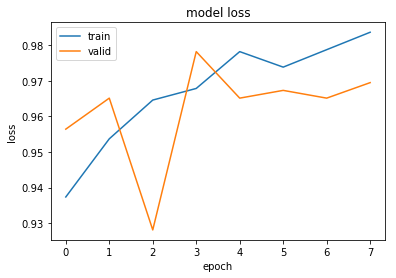

In [140]:
plt.plot(hist3.history['acc'])
plt.plot(hist3.history['val_acc'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

hist4 = model.fit_generator(train_gen,
                    steps_per_epoch=(train_gen.n//batch_size)+1,
                    validation_data=val_gen,
                    validation_steps=(val_gen.n//batch_size)+1,
                    epochs=50,
                    callbacks=[early_stopping])

Epoch 1/50
368/368 [==============================] - 298s - loss: 0.0679 - acc: 0.9761 - val_loss: 0.0765 - val_acc: 0.9847
Epoch 2/50
116/368 [========>.....................] - ETA: 168s - loss: 0.0399 - acc: 0.9845

In [145]:
hist4.history

{'acc': [0.97603485981623328,
  0.98366013169288635,
  0.9842047939697901,
  0.9831154694159826,
  0.98856209218502045,
  0.9891067544619242,
  0.99291939040025079],
 'loss': [0.067991047682415651,
  0.045657748589312555,
  0.038748488326475095,
  0.03769434610627849,
  0.034792641343198621,
  0.029026156038299781,
  0.022005224076484399],
 'val_acc': [0.98474945624669397,
  0.98257080713907874,
  0.9891067544619242,
  0.98692810535430908,
  0.99128540356953943,
  0.97821350892384851,
  0.98692810535430908],
 'val_loss': [0.076462542895143135,
  0.075999496687243623,
  0.033273871526067228,
  0.053444825692974006,
  0.061593734980861438,
  0.11379778407116613,
  0.089873482114858821]}

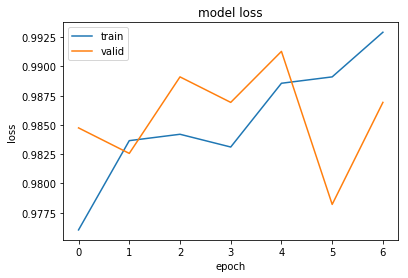

In [144]:
plt.plot(hist4.history['acc'])
plt.plot(hist4.history['val_acc'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [146]:
batch_size=1
preds = model.predict_generator(test_gen, (test_gen.n//batch_size), workers=2).flatten()

array([  5.63764079e-05,   1.62924977e-03,   1.64495048e-03,
         1.00000000e+00,   1.59299269e-03], dtype=float32)

In [150]:
preds[:10]

array([  5.63764079e-05,   1.62924977e-03,   1.64495048e-03,
         1.00000000e+00,   1.59299269e-03,   1.00000000e+00,
         2.70144636e-04,   1.51348431e-04,   1.00000000e+00,
         1.00000000e+00], dtype=float32)

In [147]:
fnames = te_batches.filenames
fnames[:5]

['unknown/324.jpg',
 'unknown/47.jpg',
 'unknown/966.jpg',
 'unknown/1526.jpg',
 'unknown/487.jpg']

In [148]:
names = np.array(list(map(lambda x: x[8:].split('.')[0], fnames)))

In [149]:
print(names.shape, preds.shape)

(1531,) (1531,)


In [151]:
# round preds
preds_round = []

for pred in preds:
    if (pred > .5):
        preds_round.append("1")
    else:
        preds_round.append("0")

In [160]:
subm_data = np.stack((names, np.array(preds_round)), axis=1)
subm_data.shape

(1531, 2)

In [161]:
df = pd.DataFrame(subm_data, columns=['name','invasive'])
df.head()

,name,invasive
0,324,0
1,47,0
2,966,0
3,1526,1
4,487,0


In [162]:
df.to_csv(os.path.join(DATA_DIR, 'results', 'subm_june_9_2017.gz'), index=False, compression='gzip')

In [163]:
!touch $DATA_DIR/results/*
%ls -lah $DATA_DIR/results

total 280K
drwxr-x--- 2 yns207 yns207 4,0K  9 juin  12:29 ./
drwxr-x--- 6 yns207 yns207 4,0K  1 juin  20:55 ../
-rw-r----- 1 yns207 yns207  17K  9 juin  12:31 subm_june_1_2017_2.gz
-rw-r----- 1 yns207 yns207  19K  9 juin  12:31 subm_june_1_2017_3.gz
-rw-r----- 1 yns207 yns207  19K  9 juin  12:31 subm_june_1_2017_4.gz
-rw-r----- 1 yns207 yns207  19K  9 juin  12:31 subm_june_1_2017_5.gz
-rw-r----- 1 yns207 yns207  14K  9 juin  12:31 subm_june_1_2017_6.gz
-rw-r----- 1 yns207 yns207  17K  9 juin  12:31 subm_june_1_2017.gz
-rw-r----- 1 yns207 yns207  14K  9 juin  12:31 subm_june_2_2017.gz
-rw-r----- 1 yns207 yns207 3,4K  9 juin  12:31 subm_june_8_2017_2.gz
-rw-r----- 1 yns207 yns207  15K  9 juin  12:31 subm_june_8_2017.gz
-rw-r----- 1 yns207 yns207 3,4K  9 juin  12:31 subm_june_9_2017_2.gz
-rw-r----- 1 yns207 yns207 3,4K  9 juin  12:31 subm_june_9_2017.gz
-rw-r----- 1 yns207 yns207  18K  9 juin  12:31 subm_may_27_2017_2.gz
-rw-r----- 1 yns207 yns207  17K  9 juin  12:31 subm_may_27_2017.gz
-

In [ ]:
# so waht did i change?
# i  used the vgg average and not the one i calculated to subtract from pixels
# batch size changed to 5.
# binary class mode is needed to use 1 output node with the sigmoid activation
# imag sizing changed to 600 450
# used rmsprop instaed of adam
# differences between my implementation and the kaggle kernel: i trained on lareg imgs first, then on smaller
# did that make a difference? -> it looks like training on smaller images AFTER bigs ones makse validation accurracy worse
# but this doesntm ean that the other wya around isnt good.
#added dropout on the last layer between the dense and output node
# which of these is superficial or made things worse? which actually made things better
# could we get a better result by adding two layers one with more nodes, then less nodes so it focuses
# could we get a better result by resizing images?
# what abut adding bathcnorm? waht about using a bathcnormed vgg16
# what about psuedo labelling?
# what about resnet? 
# check out this idea: http://blog.kaggle.com/2017/04/20/dogs-vs-cats-redux-playground-competition-3rd-place-interview-marco-lugo/